In [1]:
import nltk.data
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")


from IPython.display import display
import timeit
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import operator 

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sentiment
#from autocorrect import spell # For spelling correction
from urllib import request

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

## Download the data from dropbox, it might take a few minutes to run...

In [3]:
import pandas as pd
import requests
from io import StringIO

url = requests.get('https://www.dropbox.com/s/nhw9v19xij8lrci/Amazon_Unlocked_Mobile.csv?dl=1')
csv_raw = StringIO(url.text)
df = pd.read_csv(csv_raw)

In [4]:
# df = pd.read_csv('reference/Amazon_Unlocked_Mobile.csv', delimiter = ",")
n = len(df)
df.columns = ['Product', 'Brand', 'Price', 'Rating', 'Review', 'Votes']
df['id_col'] = range(0, n)
df['Label'] = 0
df.loc[df['Rating'] > 3, 'Label'] = 1
df.loc[df['Rating'] < 3, 'Label'] = -1


df.head()

,Product,Brand,Price,Rating,Review,Votes,id_col,Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,0,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1,1
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,2,1
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,3,1
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,4,1


In [5]:
df.shape

(413840, 8)

In [6]:
df["Brand"].isnull().sum()

65171

In [7]:
df.dropna(subset=['Review'], how='all', inplace=True)
df.shape

(413778, 8)

In [7]:
def clean_review(review, remove_stopwords = False):
    """Helper function to clean the reviews i.e. to convert a document to a sequence of words.
     Please note that we're not removing stopwords since word2vec relies on the broader context
     of the sentence in order to produce high-quality word vectors.

     Arg: review: review string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: cleaned_review : Cleaned review (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    
    review_html = BeautifulSoup(review).get_text() 
    letter = re.compile('[^a-zA-Z]')
    review_letter = re.sub(letter,' ',review_html)
    review_lower = review_letter.lower().split()
    cleaned_review = []
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        for w in review_lower:
#             if w not in stop_words:
#                 cleaned_review.append(w)
            if w not in stop_words:
                cleaned_review.append(get_synonym(w))
#                 = [w for w in review_lower if w not in stop_words]
    else:
         for w in review_lower:
#             if w not in ok_words:
#                 b = TextBlob(w)
#                 word = str(b.correct())
#                 cleaned_review.append(word) 
            cleaned_review.append(w)
#         cleaned_review = review_lower
    

    #####################
    
    return cleaned_review

def get_synonym(word):
    synonyms = [["camera","video", "display"], 
                ["phone", "cellphone", "smartphone", "phones"],
               ["setting", "settings"],
               ["feature", "features"],
               ["pictures", "photos", "picture", "photo"],
               ["speakers", "speaker"]]
    synonyms_parent = ["camera", "phone", "settings", "features", "photos", "speakers"]
    
    for i in range(len(synonyms)):
        if word in synonyms[i]:
            return synonyms_parent[i]
    
    return word

In [10]:
clean_review(df['Review'][0], remove_stopwords=True)

['feel',
 'lucky',
 'found',
 'used',
 'phone',
 'us',
 'used',
 'hard',
 'phone',
 'line',
 'someone',
 'upgraded',
 'sold',
 'one',
 'son',
 'liked',
 'old',
 'one',
 'finally',
 'fell',
 'apart',
 'years',
 'want',
 'upgrade',
 'thank',
 'seller',
 'really',
 'appreciate',
 'honesty',
 'said',
 'used',
 'phone',
 'recommend',
 'seller',
 'highly',
 'would']

In [8]:
def review_to_sentences(review, tokenizer):
    """Helper function to split a review into parsed sentences. Returns a 
     list of sentences, where each sentence is a list of words.

     Arg: review: review string (str)
          tokenizer: punkt tokenizer
     Returns:
          review_sentences: List of list of tokens.
                            e.g. [["word2vec", "was", "introduced", "by", "google" ],["it","leverages","distributed","token","representations"]]

     You should carry out the following steps.
     1. Use the tokenizer to split the paragraph into sentences.
     2. Clean the sentence to return a list of words for each sentence using the helper funtion above.
     3. Return a list of tokenized sentences.
    """
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(clean_review(raw_sentence))
    
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences
    


In [9]:
# Use the above helper functions to convert the reviews in train["review"] and in unlabeled_train["review"] to a list of list format as mentioned above.
# For example if your train data contains 2 reviews with 3 sentences in each and the unlabeled_train has 4 reviews with 1 sentence in each
# The resultant list should have 10 lists of tokenized sentences.
sentences = []  # Initialize an empty list of sentences
from collections import defaultdict 
sentence_id=defaultdict()
print("Parsing sentences from training set")
### Add your code here.
tic=timeit.default_timer()
i = 1
for i in df['id_col']:
    for review in df[df['id_col']==i]['Review']:
        sentence=review_to_sentences(review, tokenizer)
        sentences += sentence
        sentence_id[i] = sentence
    if i%10000 == 0:
        print('progress: ', (i/len(df["Review"]))*100, "%")
    i = i + 1

    toc=timeit.default_timer()

print("minutes: ", (toc - tic)/60)


Parsing sentences from training set
progress:  0.0 %
progress:  2.416754878219722 %
progress:  4.833509756439444 %
progress:  7.250264634659165 %
progress:  9.667019512878888 %
progress:  12.08377439109861 %
progress:  14.50052926931833 %
progress:  16.91728414753805 %
progress:  19.334039025757775 %
progress:  21.750793903977495 %
progress:  24.16754878219722 %
progress:  26.584303660416936 %
progress:  29.00105853863666 %
progress:  31.417813416856383 %
progress:  33.8345682950761 %
progress:  36.25132317329582 %
progress:  38.66807805151555 %
progress:  41.08483292973527 %
progress:  43.50158780795499 %
progress:  45.91834268617471 %
progress:  48.33509756439444 %
progress:  50.75185244261415 %
progress:  53.16860732083387 %
progress:  55.5853621990536 %
progress:  58.00211707727332 %
progress:  60.418871955493046 %
progress:  62.835626833712766 %
progress:  65.25238171193249 %
progress:  67.6691365901522 %
progress:  70.08589146837193 %
progress:  72.50264634659165 %
progress:  74.

In [15]:
print(sentences[0])

['i', 'feel', 'so', 'lucky', 'to', 'have', 'found', 'this', 'used', 'phone', 'to', 'us', 'not', 'used', 'hard', 'at', 'all', 'phone', 'on', 'line', 'from', 'someone', 'who', 'upgraded', 'and', 'sold', 'this', 'one']


In [16]:
import itertools
len(list(itertools.chain(*sentence_id[0][0])))


103

## 0. Raw Data Statistics

In [10]:
import collections
import itertools

#words_in_review = [rev for rev in sentences]
wordlist=list(itertools.chain(*sentences))
counts=collections.Counter(wordlist)

In [18]:
# number of vocabulary
len(counts)

60695

In [19]:
# number of word per sentence
len(wordlist)/len(sentences)

13.921884739592652

In [20]:
# number of sentence per reviews
len(sentences)/len(df)

2.9582602264982674

In [21]:
df.describe()

,Price,Rating,Votes,id_col,Label
count,407848.000000,413778.000000,401482.000000,413778.000000,413778.000000
mean,226.867148,3.819609,1.506155,206919.955887,0.454091
std,273.019444,1.548212,9.162444,119463.506787,0.846782
min,1.730000,1.000000,0.000000,0.000000,-1.000000
25%,79.990000,3.000000,0.000000,103465.250000,0.000000
50%,144.710000,5.000000,0.000000,206914.500000,1.000000
75%,269.990000,5.000000,1.000000,310372.750000,1.000000
max,2598.000000,5.000000,645.000000,413839.000000,1.000000


In [22]:
len(sentences)

1224063

In [23]:
s_v=[]

for i in sentence_id.keys():
    s_v.append(len(sentence_id[i][0]))

    
    

In [24]:
df['sentence per review']=s_v

In [25]:

w_t=[len(i) for i in sentences]
min(w_t), max(w_t), np.mean(w_t), np.median(w_t),np.std(w_t)

(0, 742, 13.921884739592652, 10.0, 14.448212892155757)

In [26]:
len(df['Brand'].unique())

385

In [35]:
import sys  
!{sys.executable} -m pip install statsmodels 

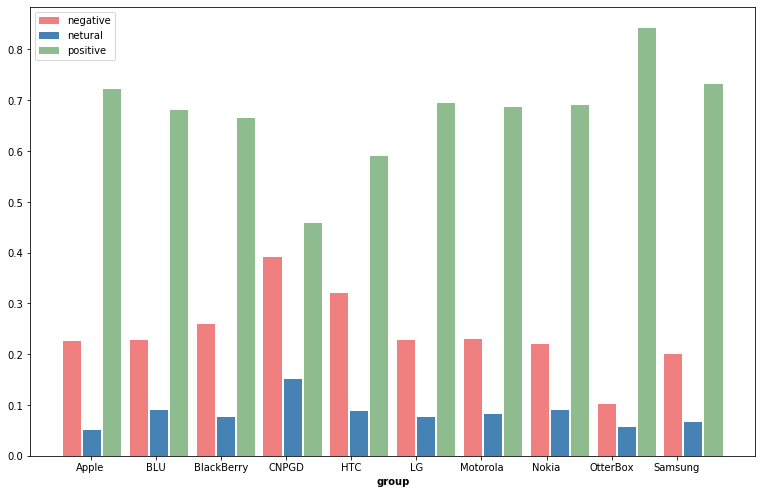

In [183]:
brand_count=df['Brand'].value_counts()
brand_count=brand_count[:10,]
plt.figure(figsize=(13,8))
top10=df[df['Brand'].isin(brand_count.index)]


barWidth=0.9

top10label=top10.groupby(['Brand','Label'])['Product'].size().reset_index(name='prod_count')
a = top10label.groupby('Brand')['prod_count'].transform('sum')
top10label['prod_count'] = top10label['prod_count'].div(a)
bars1=list(top10label[top10label['Label']==-1]['prod_count'])
bars2=list(top10label[top10label['Label']==0]['prod_count'])
bars3=list(top10label[top10label['Label']==1]['prod_count'])
bars4 = bars1+bars2+bars3


r1 = np.linspace(0,30,num=10,retstep=3)[0]
r2 = np.linspace(1,31,num=10,retstep=3)[0]
r3 = np.linspace(2,32,num=10,retstep=3)[0]
r4 = list(r1) + list(r2) + list(r3)

plt.bar(r1, bars1, width = barWidth, color = '#F08080', label='negative')
plt.bar(r2, bars2, width = barWidth, color = '#4682B4', label='netural')
plt.bar(r3, bars3, width = barWidth, color = "#8FBC8F", label='positive')

label=top10label['prod_count'].round(2).tolist()
plt.xlabel('group', fontweight='bold')
plt.xticks([(r +barWidth)*3.25-2 for r in range(10)], sorted(brand_count.reset_index()['index'].tolist()))
#for i in range(len(r4)):
    #plt.text(x = r4[i]-0.4 , y = bars4[i]+0.01, s = label[i], size = 7)
plt.subplots_adjust(bottom= 0.2, top = 0.98)

plt.legend(loc=2)



# import dexplot as dxp
# ax=dxp.aggplot(agg='Brand', data=top10, hue='Label', normalize='Brand')



#t10 = top10.groupby(['Brand', 'Label'])['Brand'].count().unstack('Label').fillna(0)
#t10.plot(kind='bar', stacked=True,cmap="Set2")

1     0.050517
4     0.090219
7     0.076754
10    0.150400
13    0.088337
16    0.076751
19    0.083253
22    0.090449
25    0.056216
28    0.066745
Name: prod_count, dtype: float64

In [ ]:
def plot_one_company(company, n=20):
    df_one_company = df_small.loc[df_small['BrandName'].isin([company])]
    pivot = pd.pivot_table(df_one_company,
            values = ['Rating', 'Votes'],
            index =  ['Product'],
                       columns= [],
                       aggfunc=[np.sum, np.mean, np.count_nonzero, np.std], 
                       margins=True, fill_value=0).sort_values(by=('count_nonzero', 'Rating'), ascending=False).fillna('')
    top_10_prods = pivot.reindex().head(n=20)
    top_10_prods = top_10_prods.reset_index()
    tt_prods = top_10_prods['Product']
    tt_prods2 = tt_prods.reset_index()
    top_10_prods_list = list(set(tt_prods2['Product']))


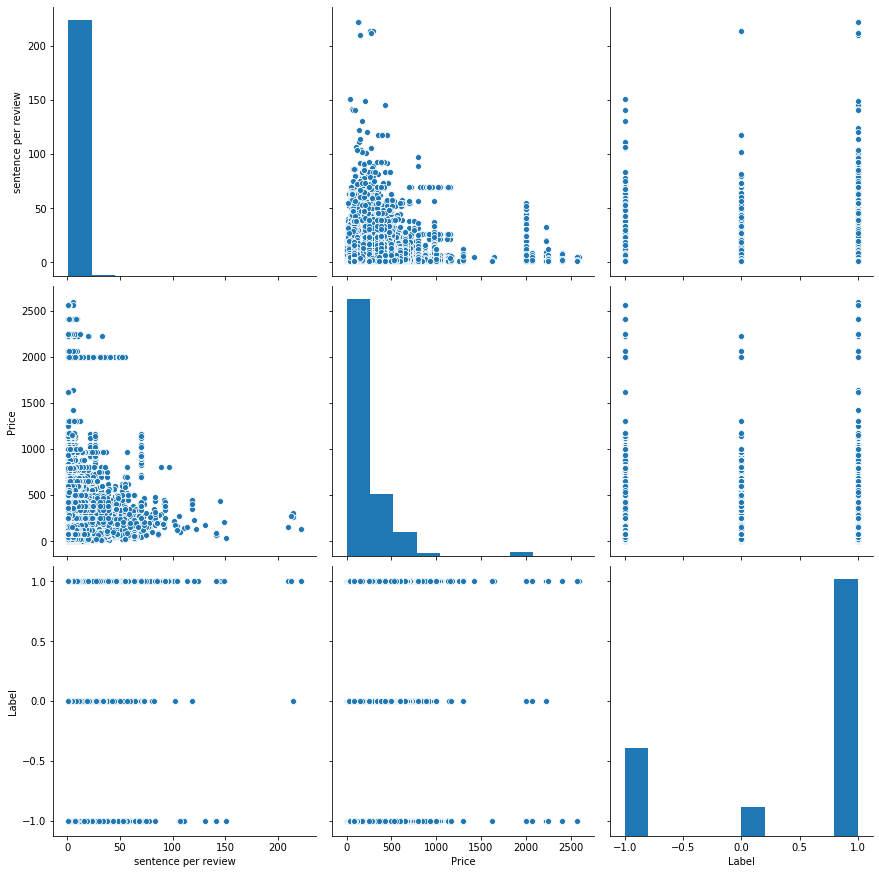

In [155]:
df_small = df[['sentence per review','Price',  
               'Label']]
sns.pairplot(df_small, size=4)

In [38]:
#correlation
from scipy.stats import spearmanr
#np.cov(df['Label'],df['Price'])
corr,_=spearmanr(df['Label'],df['sentence per review'], nan_policy='omit')
corr

-0.2838848690991236

In [39]:

corr,_=spearmanr(df['Label'],df['Price'], nan_policy='omit')
corr

0.09572076847472662

In [40]:
import scipy.stats as stats
stats.f_oneway(df[df['Label'] == 1]['sentence per review'], 
             df[df['Label'] == 0]['sentence per review'],
             df[df['Label'] == -1]['sentence per review'])

F_onewayResult(statistic=6890.849716473914, pvalue=0.0)

In [41]:
df2=df.copy()
df2=df2.dropna()

stats.f_oneway(df2[df2['Label'] == 1]['Price'], 
             df2[df2['Label'] == 0]['Price'],
             df2[df2['Label'] == -1]['Price'])

F_onewayResult(statistic=939.3638595335217, pvalue=0.0)

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison( df2['Price'],df2['Label'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
    -1      0  -13.212 0.001 -17.9499 -8.4741   True
    -1      1  41.9171 0.001   39.171 44.6633   True
     0      1  55.1291 0.001  50.8044 59.4539   True
----------------------------------------------------


In [44]:
mc = MultiComparison( df2['sentence per review'],df2['Label'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    -1      0  -0.0966 0.6174 -0.3427  0.1495  False
    -1      1  -5.8605  0.001 -6.0031 -5.7178   True
     0      1  -5.7639  0.001 -5.9886 -5.5392   True
----------------------------------------------------


Text(0.5, 1.0, 'Proportion of Each Label Class')

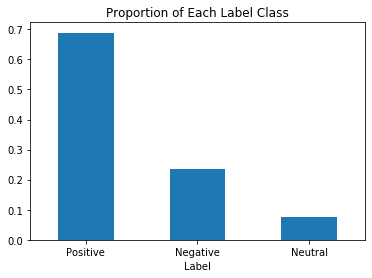

In [46]:

prop_df = (df['Label']
           .value_counts(normalize=True)
           .rename('percentage')
           .reset_index())
prop_df=prop_df.rename(columns={'index':'Label'})
ax=prop_df['percentage'].plot(kind='bar')
ax.set_xlabel('Label')
ax.set_xticklabels(['Positive','Negative','Neutral'],rotation=360)
ax.set_title('Proportion of Each Label Class')

Text(0.5, 1.0, 'Proportion of Five Ratings')

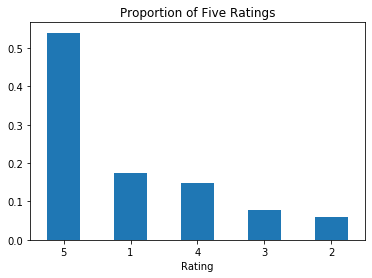

In [47]:
prop_df = (df['Rating']
           .value_counts(normalize=True)
           .rename('percentage')
           .reset_index())
prop_df=prop_df.rename(columns={'index':'Rating'})
ax=prop_df['percentage'].plot(kind='bar')
ax.set_xlabel('Rating')
ax.set_xticklabels(prop_df['Rating'],rotation=360)
ax.set_title('Proportion of Five Ratings')

In [65]:
negrev=[]
for i in df[df['Label']==-1].index.tolist():
    negrev.append(sentences[i])

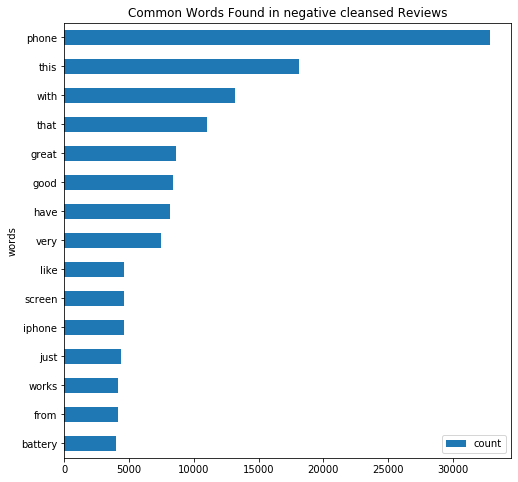

In [164]:
nwordlist=list(itertools.chain(*negrev))
ncounts=collections.Counter(nwordlist)
ncwl=[]
for i in ncounts.most_common(70):
    if len(i[0])>3:
        ncwl.append(i)
ncountsdf= pd.DataFrame(ncwl[:15],
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))

countsdf.sort_values(by='count').plot.barh(x='words',y='count',
                      ax=ax,)
ax.set_title("Common Words Found in negative cleansed Reviews")
plt.show()
        

In [167]:
countsdf['words']

0       phone
1        this
2        with
3        that
4       great
5        good
6        have
7        very
8      screen
9        like
10       just
11      works
12    battery
13     iphone
14       from
Name: words, dtype: object

In [169]:
ncountsdf
ncountsdf.merge(countsdf, left_on='words', right_on='words')


,words,count_x,count_y
0,phone,32833,99236
1,this,18079,52620
2,with,13138,38260
3,that,11011,32011
4,great,8579,25267
5,good,8407,24732
6,have,8131,23580
7,very,7455,22422
8,like,4608,13543
9,screen,4606,13764


In [69]:
posrev=[]
for i in df[df['Label']==1].index.tolist():
    posrev.append(sentences[i])
    

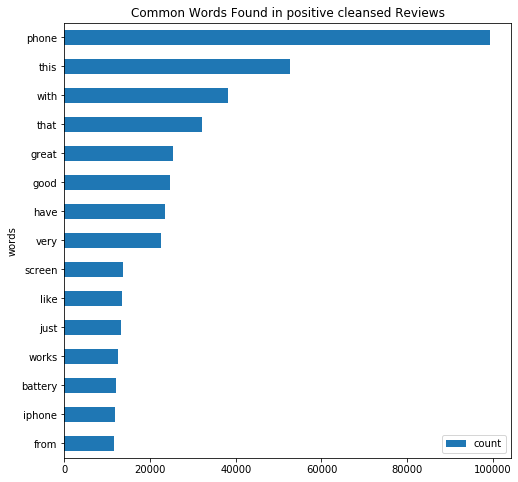

In [168]:
pwordlist=list(itertools.chain(*posrev))
pcounts=collections.Counter(pwordlist)
pcwl=[]
for i in pcounts.most_common(70):
    if len(i[0])>3:
        pcwl.append(i)
countsdf= pd.DataFrame(pcwl[:15],
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))

countsdf.sort_values(by='count').plot.barh(x='words',y='count',
                      ax=ax,)
#clrs = ['grey' if (x in ['phone','screen','good','great','this','with','that','very','have','battery','iphone']) else 'red' for x in values ]
ax.set_title("Common Words Found in positive cleansed Reviews")
plt.show()
        